<a href="https://colab.research.google.com/github/Mubasshir-Ali/Deep_Learning_Practice/blob/master/12_Color_Images_Cats_Vs_Dogs_Saving_And_Loading_Models_Using_CNNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
!pip install -U tensorflow_hub
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_hub in /usr/local/lib/python3.6/dist-packages (0.8.0)
     |████████████████████████████████| 3.3MB 3.3MB/s 
  Found existing installation: tensorflow-datasets 2.1.0
    Uninstalling tensorflow-datasets-2.1.0:
      Successfully uninstalled tensorflow-datasets-2.1.0


In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

# Part 1: Load the Cats vs. Dogs Dataset

In [0]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    split = ['train[:80%]', 'train[80%:]'], 
    with_info = True, 
    as_supervised = True,
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteIAT9V5/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [0]:
# The images in the Dogs vs. Cats dataset are not all the same size. So, we need to reformat all images to the resolution expected by MobileNet (224, 224)
def format_image(image, label):
  # `hub` image modules exepct their data normalized to the [0,1] range.
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

num_examples = info.splits['train'].num_examples

BATCH_SIZE = 32
IMAGE_RES = 224

train_batches = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

# Part 2: Transfer Learning with TensorFlow Hub

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, 
                                   input_shape = (IMAGE_RES, IMAGE_RES, 3))

In [0]:
feature_extractor.trainable = False

# Attach A classification Head

In [0]:
model = tf.keras.Sequential([
  feature_extractor, 
  layers.Dense(2)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


# Train The Model

In [0]:
# We now train this model like any other, by first calling compile followed by fit.
model.compile(
    optimizer = 'adam', 
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits = True), 
    metrics = ['accuracy']
)

EPOCHS = 3
history = model.fit(train_batches, 
                    epochs = EPOCHS, 
                    validation_data = validation_batches)

Epoch 1/3
582/582 [==============================] - 52s 89ms/step - loss: 0.0224 - accuracy: 0.9921 - val_loss: 0.0330 - val_accuracy: 0.9899
Epoch 2/3
582/582 [==============================] - 52s 89ms/step - loss: 0.0189 - accuracy: 0.9932 - val_loss: 0.0326 - val_accuracy: 0.9903
Epoch 3/3
582/582 [==============================] - 52s 89ms/step - loss: 0.0176 - accuracy: 0.9944 - val_loss: 0.0335 - val_accuracy: 0.9903


# Check The Predictions

In [0]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [0]:
# Run an image batch through the model and convert the indices to class names.
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis = -1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat',
       'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat',
       'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog',
       'dog', 'dog', 'cat', 'dog', 'dog'], dtype='<U3')

In [0]:
print("Labels: ", label_batch)
print("Predicted Labels: ", predicted_ids)

Labels:  [1 0 0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1]
Predicted Labels:  [1 0 0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1]


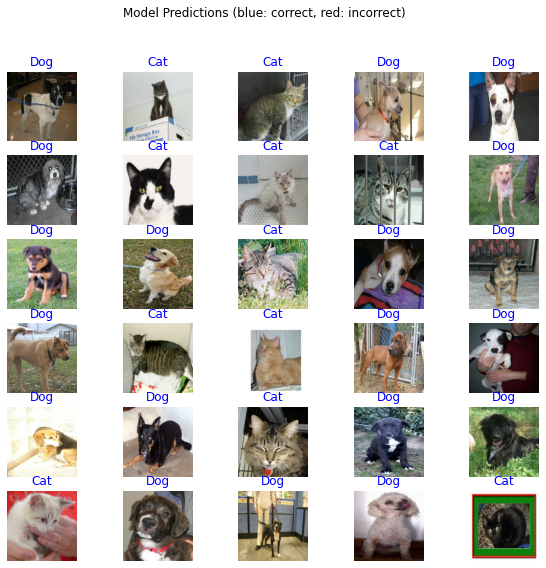

In [0]:
plt.figure(figsize = (10, 9))
for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color =color)
  plt.axis('off')
  _ = plt.suptitle("Model Predictions (blue: correct, red: incorrect)")

# Part 3: Save as Keras .h5 Model
Now that we've trained the model, we can save it as an HDF5 file, which is the format used by Keras. Our HDF5 file will have the extension '.h5', and it's name will correpond to the current time stamp.

In [0]:
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1588620566.h5


In [0]:
!ls

1588620566.h5  sample_data


You can later recreate the same model from this file, even if you no longer have access to the code that created the model.

This file includes:

* The model's architecture
* The model's weight values (which were learned during training)
* The model's training config (what you passed to compile), if any
* The optimizer and its state, if any (this enables you to restart training where you left off)

# Part 4: Load The Keras .h5 Model
We will now load the model we just saved into a new model called reloaded. We will need to provide the file path and the custom_objects parameter. This parameter tells keras how to load the hub.KerasLayer from the feature_extractor we used for transfer learning.

In [0]:
reloaded = tf.keras.models.load_model(
    export_path_keras, 
    # `custom_objects` tells keras how to load a `hub.KerasLayer`
    custom_objects = {'KerasLayer': hub.KerasLayer}
)

reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
# We can check that the reloaded model and the previous model give the same result
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [0]:
# The difference in output should be zero:
(abs(result_batch - reloaded_result_batch)).max()

0.0

# Keep Training
Besides making predictions, we can also take our reloaded model and keep training it. To do this, you can just train the reloaded as usual, using the .fit method.

In [0]:
EPOCHS = 3
history = reloaded.fit(train_batches, 
                       epochs = EPOCHS, 
                       validation_data = validation_batches)

Epoch 1/3
582/582 [==============================] - 52s 89ms/step - loss: 0.0219 - accuracy: 0.9923 - val_loss: 0.0343 - val_accuracy: 0.9893
Epoch 2/3
582/582 [==============================] - 51s 88ms/step - loss: 0.0211 - accuracy: 0.9924 - val_loss: 0.0335 - val_accuracy: 0.9895
Epoch 3/3
582/582 [==============================] - 52s 89ms/step - loss: 0.0166 - accuracy: 0.9944 - val_loss: 0.0323 - val_accuracy: 0.9903


# Part 5: Export as SavedModel
You can also export a whole model to the TensorFlow SavedModel format. SavedModel is a standalone serialization format for Tensorflow objects, supported by TensorFlow serving as well as TensorFlow implementations other than Python. A SavedModel contains a complete TensorFlow program, including weights and computation. It does not require the original model building code to run, which makes it useful for sharing or deploying (with TFLite, TensorFlow.js, TensorFlow Serving, or TFHub).

The SavedModel files that were created contain:
* A TensorFlow checkpoint containing the model weights.
* A SavedModel proto containing the underlying Tensorflow graph. Separate graphs are saved for prediction (serving), train, and evaluation. If the model wasn't compiled before, then only the inference graph gets exported.
* The model's architecture config, if available.

Let's save our original model as a TensorFlow SavedModel. To do this we will use the tf.saved_model.save() function. This functions takes in the model we want to save and the path to the folder where we want to save our model.

This function will create a folder where you will find an assets folder, a variables folder, and the saved_model.pb file.

In [0]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./1588621530
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./1588621530/assets


INFO:tensorflow:Assets written to: ./1588621530/assets


In [0]:
!ls{export_path_sm}

/bin/bash: ls./1588621530: No such file or directory


# Part 6: Load SavedModel
Now, let's load our SavedModel and use it to make predictions. We use the tf.saved_model.load() function to load our SavedModels. The object returned by tf.saved_model.load is 100% independent of the code that created it.

In [0]:
reloaded_sm = tf.saved_model.load(export_path_sm)

In [0]:
# Now, let's use the reloaded_sm (reloaded SavedModel) to make predictions on a batch of images.
reload_sm_result_batch = reloaded_sm(image_batch, training = False).numpy()

In [0]:
# We can check that the reloaded SavedModel and the previous model give the same result.
(abs(result_batch - reload_sm_result_batch)).max()

0.0

# Part 7: Loading the SavedModel as a Keras Model
The object returned by tf.saved_model.load is not a Keras object (i.e. doesn't have .fit, .predict, .summary, etc. methods). Therefore, you can't simply take your reloaded_sm model and keep training it by running .fit. To be able to get back a full keras model from the Tensorflow SavedModel format we must use the tf.keras.models.load_model function. This function will work the same as before, except now we pass the path to the folder containing our SavedModel.

In [0]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)
tf.saved_model.save(model, export_path_sm)

./1588621947
INFO:tensorflow:Assets written to: ./1588621947/assets


INFO:tensorflow:Assets written to: ./1588621947/assets


In [0]:
reload_sm_keras = tf.keras.models.load_model(
    export_path_sm, 
    custom_objects = {'KerasLayer': hub.KerasLayer}
)

reload_sm_keras.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,226,434
Non-trainable params: 34,112
_________________________________________________________________


In [0]:
# Now, let's use the reloaded_sm)keras (reloaded Keras model from our SavedModel) to make predictions on a batch of images.
result_batch = model.predict(image_batch)
reload_sm_keras_result_batch = reload_sm_keras.predict(image_batch)

In [0]:
# We can check that the reloaded Keras model and the previous model give the same result.
(abs(result_batch - reload_sm_keras_result_batch)).max()

0.0

# Part 8: Download Your Model
You can download the SavedModel to your local disk by creating a zip file. We wil use the -r (recursice) option to zip all subfolders.

In [0]:
!zip -r model.zip {export_path_sm}

updating: 1588621947/ (stored 0%)
updating: 1588621947/variables/ (stored 0%)
updating: 1588621947/variables/variables.data-00000-of-00002 (deflated 88%)
updating: 1588621947/variables/variables.index (deflated 79%)
updating: 1588621947/variables/variables.data-00001-of-00002 (deflated 7%)
updating: 1588621947/saved_model.pb (deflated 92%)
updating: 1588621947/assets/ (stored 0%)


In [0]:
# The zip file is saved in the current working directory. You can see what the current working directory is by running:
!ls

1588620566.h5
1588621530
1588621947
Color_Images_Cats_Vs_Dogs_Saving_And_Loading_Models_Using_CNNS.zip
model.zip
sample_data


In [0]:
# Once the file is zipped, you can download it to your local disk
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

The files.download command will search for files in your current working directory. If the file you want to download is in a directory other than the current working directory, you have to include the path to the directory where the file is located.